In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as skl
from sklearn import *
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import time
%matplotlib

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    # sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
import TuningCurveFuncs
from TuningCurveFuncs import createFeatureBins, visualise_FeatureBins


subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
nsubs = subs.size

#get bin structure for data we want to load in
weightTrials = True #whether trial contributions to mean activity for a reference bin are weighted by distance from the bin centre
# binstep, binwidth = 4, 11 #4 degree jumps, 22 degree full width
# binstep, binwidth = 4, 16 #4 degree jumps, 32 degree full width
# binstep, binwidth = 4, 22 #4 degree jumps, 44 degree full width
# binstep, binwidth = 15, 10 #jumps of 15 degrees, 20 degree full width 
# binstep, binwidth = 15, 15 #jumps of 15 degrees, 30 degree full width
binstep, binwidth = 15, 22 #jumps of 15 degrees, 44 degree full width
_, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -90+binstep, feature_end = 90)
thetas = np.cos(np.radians(binmids))
binmidsrad = np.deg2rad(binmids)

visualise_bins = False
if visualise_bins:
    visualise_FeatureBins(binstarts, binmids, binends)
times = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
#some parameters to control what the model is doing
smooth_alphas = True


i=4
print(f'\n\nworking on participant {i}')

if smooth_alphas:
    smooth_sigma = 3
    print('modelling with smooth alpha values')
elif not smooth_alphas:
    smooth_sigma = None
    print('modelling with raw alpha values')

data = np.load(op.join(wd, 'data', 'tuningcurves',
                       f's{i}_TuningCurve_mahaldists_binstep{binstep}_binwidth{binwidth}_weightTrials{weightTrials}.npy'))
[nitems, ntrials, nbins, ntimes] = data.shape

bdata = pd.read_csv(op.join(wd, 'data', 'tuningcurves', f's{i}_TuningCurve_metadata.csv')) #read in associated behavioural data

data = data * -1 #sign flip mahalanobis distances so that larger (more positive) values reflect more similar representations
d = data.copy()
dm = data.copy()
dz = data.copy()
#demean the vector of distances at each time point, separately for each item and trial
# for iitem in range(nitems):
#     for itrl in range(ntrials):
#         for tp in range(ntimes):
#             dm[iitem, itrl,:, tp] = np.subtract(d[iitem, itrl, :, tp], np.mean(d[iitem, itrl, :, tp]))#.mean()) #demean

#if this loop above gets prohibitively slow, then you can also do this below: (it's different because finite precision isnt associative even if the math operation is) 
imean = np.mean(data.copy(), axis=2, keepdims=True)
dm = np.subtract(d.copy(), imean)

#we also want to zscore the single trial distances to have a copy that has [mean, var] [0, 1]
dz = sp.stats.zscore(dz, axis=2) #zscore along the feature bin axis


tp=61 #choose a time point around when we know there is structure (0.2s post stimulus array)
tmp = d[0,:,:,tp].copy().mean(0) #get average across trials for the left item, at this time point (just to get something smoother)
tmpdz = dz[0, :, :, tp].copy().mean(0) #get same but from the zscored values
tmpdm = dm[0,:,:,tp].copy().mean(0) #get same but from the demeaned distance values

Using matplotlib backend: module://matplotlib_inline.backend_inline


working on participant 4
modelling with smooth alpha values


<font color='red'>

first, define some functions that we are going to use in fitting procedures:

1 - a function describing a gaussian where $X \sim \mathcal{N}(0, \sigma)$, where sigma is estimated from the data -- this basically estimates a normal pdf over the z-scored distances

2 - a function describing a model where distances are a multiplier of this gaussian: it effectively describes a model where $d \sim \beta_1\ *\ \mathcal{N}(0, sigma)$. Not sure how this should actually be written in math notation (?), but effectively you get the pdf of the z-scored distances and describe the demeaned distances as a multiplier of this pdf

3 -  a function describing a more full model, where distances follow a model where: $d \sim \beta_0 + \beta_1\ *\ \mathcal{N}(0, sigma)$

In [35]:
def gaussfunc(x, mu, sigma):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-((x-mu)**2/(2 * sigma**2)))

#define function to create a gaussian with a mean of zero
def gaussfunc_zeromean(x, sigma):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-((x-0)**2/(2 * sigma**2)))

#define function that describes a model that is a multiplier of this gaussian
# e.g. fitting distances ~ B1 * N(0, sigma) and estimating B1 where sigma is previously estimated
def gaussfunc_b1only(x, B1, sigma):
    return B1 * (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-((x-0)**2/(2 * sigma**2)))

#define function that describes a model that is a multiplier of the previously estimated gaussian, with a baseline value (intercept)
# e.g. fitting B0 + B1 * N(0, sigma) - estimating B0 and B1, where sigma was previously estimated
def gaussfunc_fullbeta(x, B0, B1, sigma):
    return B0 + B1 * (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-((x-0)**2/(2 * sigma**2)))

<font color='red'>
then we:

1 - estimate the variance of a gaussian over the z-scored distances

2 - visualise the z-scored

Text(0.5, 1.0, 'de-meaned distances (black) with best fitting normal overlaid (red)')

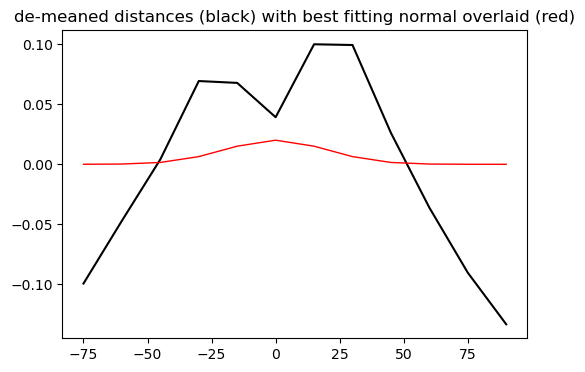

In [12]:
#first, we estimate the std deviation of a gaussian to the z-scored distances
fitsigma = sp.optimize.curve_fit(gaussfunc_zeromean,
                                 xdata = binmids,
                                 ydata = tmpdz)[0]

#we can then demonstrate what this looks like relative to the data it was modelling
fitted = gaussfunc_zeromean(binmids, sigma = fitsigma[0])

fig = plt.figure(figsize = [6,4])
ax = fig.add_subplot(111)
ax.plot(binmids, tmpdz, color='k', lw = 1.5)
ax.plot(binmids, fitted, color='r', lw = 1)
ax.set_title(f'de-meaned distances (black) with best fitting normal overlaid (red)')

<font color='red'>

here there may be an issue - the gaussian itself can only model positive values, but the z-scored distances are obviously distributed around 0. This means it probably isn't capturing the full width of the distribution of distances

anyways, next we take this estimate of $\sigma$ and pass it through to the next step, which we do in two forms:

1. model with $\beta_1$ only (multiplying this normal pdf by $\beta_1$)
2. model with $\beta_0$ and $\beta_1$, modelling the distribution of distances as a normal pdf on top of a baseline $\beta_0$ (effectively intercept)

In [15]:
#we can then estimate two models
#estimate the b1 only model
b1fit = sp.optimize.curve_fit(lambda x, B1: gaussfunc_b1only(x, B1, fitsigma),
                              xdata = binmids,
                              ydata = tmpdm)[0]

#estimate parameters for the model with B0 and B1
betafit = sp.optimize.curve_fit(lambda x, B0, B1: gaussfunc_fullbeta(x, B0, B1, fitsigma),
                                xdata = binmids,
                                ydata = tmp)[0]


Text(0.5, 1.0, '$\\beta_1$ only model')

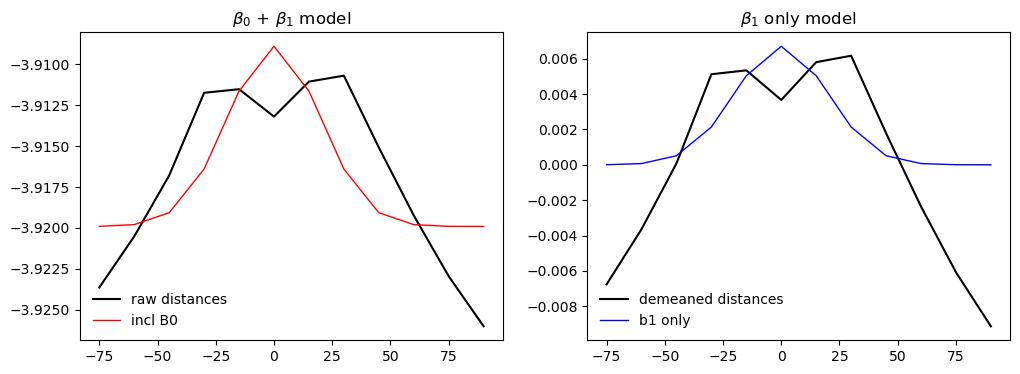

In [33]:
#get the fitted distances for the two models
fullfit = np.add(betafit[0], np.multiply(betafit[1], sp.stats.norm.pdf(binmids, loc = 0, scale = fitsigma)))
fitb1only = np.multiply(b1fit, sp.stats.norm.pdf(binmids, loc = 0, scale = fitsigma))

#and plot them
fig = plt.figure(figsize = [12, 4])
ax = fig.add_subplot(121)
ax.plot(binmids, tmp, lw = 1.5, color='k', label = 'raw distances')
ax.plot(binmids, fullfit, lw = 1, color = 'red', label = 'incl B0')
ax.legend(loc='lower left', frameon=False)
ax.set_title('$\\beta_0$ + $\\beta_1$ model')
ax=fig.add_subplot(122)
ax.plot(binmids, tmpdm, lw = 1.5, color = 'k', label = 'demeaned distances')
ax.plot(binmids, fitb1only, lw = 1, color = 'blue', label = 'b1 only')
ax.legend(loc='lower left', frameon=False)
ax.set_title('$\\beta_1$ only model')